# Correlation analysis between the Bitcoin currency and Twitter

This project consists of a correlation analysis between the Bitcoin currency and tweets. In order to define the positiveness of a tweet (if the course of the bitcoin will go up or down), we realise a sentiment analysis of each tweet using the VADER algorithm. Finally we try to find a correlation between the two and we will make some machine learning to make predictions.

This notebook was written using Python 3.6.

## Import the Python dependencies
For this project we need Pandas to manage all of our datasets.

You will need to run the following commands with pip to install the dependencies:

```
pip install VaderSentiment
pip install pandas
pip install tqdm
...
```

You can also run `pip install .` from the project's root folder to install all the requirements from the `requirements.txt` file.

In [1]:
import json
import pandas as pd
import io
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm
import glob
from datetime import datetime

## Set the currency and the data files

In [2]:
# Define the currency
#CURRENCY = "zilliqa"
#CURRENCY_SYMBOL = "ZIL"
#CURRENCY = "nexo"
#CURRENCY_SYMBOL = "NEXO"
CURRENCY = "zilliqa"
CURRENCY_SYMBOL = "ZIL"


CRYPTO_FOLDER = f"data/crypto/{CURRENCY_SYMBOL}"
TWITTER_FOLDER = f"data/twitter/{CURRENCY_SYMBOL}"

tweets_clean_file = f'{TWITTER_FOLDER}/{CURRENCY}_tweets_clean.csv'

## Load the datasets
We read the data generated from two other notebooks, TwitterExtraction and CryptoCurrencyExtraction. The data is stored in 2 CSV files. The first one contains around 430'000 tweets all related to the Bitcoin on a period of 10 days between the 10.05.2018 and the 20.05.2018. The second dataset contains the historical data of the exchange rate between Bitcoin and USD over the same period of time.

In [3]:
tweets = pd.read_csv(tweets_clean_file)

# Drop duplicate tweets
print('tweet shape before droping duplicates', tweets.shape)
duplicates_removed = tweets.shape[0]
tweets = tweets.drop_duplicates(subset=['ID'])
duplicates_removed -= tweets.shape[0]
print('tweet shape after droping duplicates', tweets.shape)
print('duplicates removed', duplicates_removed)

tweets.head(5)

tweet shape before droping duplicates (14917, 7)
tweet shape after droping duplicates (14754, 7)
duplicates removed 163


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt
0,1001428255268917250,"RT young_pfy5811 ""$EOS 🚀🔥🚀🔥 The FUD is over!! ...",Ira Cohen,4218,0,0,Tue May 29 11:41:16 +0000 2018
1,1001427808227414016,RT : Zilliqa Project Update 9 is available her...,Guido Santa Cruz,47,100,0,Tue May 29 11:39:29 +0000 2018
2,1001427793006166017,We will pump on binance at 10PM/MXL2WCQ35r$BQX...,Elliott Har,12,0,0,Tue May 29 11:39:26 +0000 2018
3,1001427581588135936,RT : Babb is my choice for the next run ! $bax...,Morpheus Nation,44,7,0,Tue May 29 11:38:35 +0000 2018
4,1001426794589949952,Cryptocurrecy trading terms 🧐💪For all cypto co...,Braveheart22,875,0,2,Tue May 29 11:35:28 +0000 2018


In [4]:
CRYPTO_SYMBOL = 'BTC'
CRYPTO_FOLDER = f"data/crypto/{CRYPTO_SYMBOL}"
crypto_files = glob.glob(f"{CRYPTO_FOLDER}/*.csv")
dfs = []
for file in crypto_files:
    dfs.append(pd.read_csv(file))
crypto_usd = pd.concat(dfs)
crypto_usd = crypto_usd.sort_values(by=['time'])

# Drop duplicates
print('bitcoin shape before droping duplicates', crypto_usd.shape)
duplicates_removed = crypto_usd.shape[0]
crypto_usd = crypto_usd.drop_duplicates(subset=['time'])
print('bitcoin shape after droping duplicates', crypto_usd.shape)
duplicates_removed -= crypto_usd.shape[0]
print('duplicates removed', duplicates_removed)
crypto_usd.head(5)

bitcoin shape before droping duplicates (30159, 5)
bitcoin shape after droping duplicates (30140, 5)
duplicates removed 19


,close,high,low,open,time
0,8737.87,8747.28,8737.63,8745.27,1526032500
1,8745.14,8745.14,8737.76,8738.79,1526032560
2,8748.48,8753.09,8744.79,8745.14,1526032620
3,8746.25,8748.76,8742.89,8748.48,1526032680
4,8753.83,8753.86,8743.80,8746.25,1526032740


## Sentiment analysis

### VADER
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

VADER takes into account 
- negations and contractions (not good, wasn’t good)
- Ponctuation (good!!!), CAPS, emotes :), emojis 
- Intensificators (very, kind of), acronyms ‘lol’
- Scores between -1.0 (negative) and 1.0 (positive)

We will use this sentiment analysis of the tweets to calculate a score that will represent the importance of each tweet.

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(tweets['Text'])):
    vs = analyzer.polarity_scores(s)
    compound.append(vs["compound"])
tweets["compound"] = compound
tweets.head(5)

100%|██████████| 14754/14754 [00:07<00:00, 1893.30it/s]


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound
0,1001428255268917250,"RT young_pfy5811 ""$EOS 🚀🔥🚀🔥 The FUD is over!! ...",Ira Cohen,4218,0,0,Tue May 29 11:41:16 +0000 2018,-0.6145
1,1001427808227414016,RT : Zilliqa Project Update 9 is available her...,Guido Santa Cruz,47,100,0,Tue May 29 11:39:29 +0000 2018,0.0000
2,1001427793006166017,We will pump on binance at 10PM/MXL2WCQ35r$BQX...,Elliott Har,12,0,0,Tue May 29 11:39:26 +0000 2018,0.0000
3,1001427581588135936,RT : Babb is my choice for the next run ! $bax...,Morpheus Nation,44,7,0,Tue May 29 11:38:35 +0000 2018,0.0000
4,1001426794589949952,Cryptocurrecy trading terms 🧐💪For all cypto co...,Braveheart22,875,0,2,Tue May 29 11:35:28 +0000 2018,0.6369


### Calculate a score for each tweet
To calculate the score for each tweet, we use different variables to which we had a weight based on its importance.

The compound column represents the sentiment of the tweets and its value is between -1 and 1.

We also use the number of retweets, the number of likes, and the number of users that follow the tweet's author.

In [6]:
scores = []
for i, s in tqdm(tweets.iterrows(), total=tweets.shape[0]):
    scores.append(s["compound"] * ((s["UserFollowerCount"]+1)) * ((s["Likes"]+1)))
tweets["Scores"] = scores
tweets.head(5)

100%|██████████| 14754/14754 [00:02<00:00, 6559.55it/s]


,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound,Scores
0,1001428255268917250,"RT young_pfy5811 ""$EOS 🚀🔥🚀🔥 The FUD is over!! ...",Ira Cohen,4218,0,0,Tue May 29 11:41:16 +0000 2018,-0.6145,-2592.5755
1,1001427808227414016,RT : Zilliqa Project Update 9 is available her...,Guido Santa Cruz,47,100,0,Tue May 29 11:39:29 +0000 2018,0.0000,0.0000
2,1001427793006166017,We will pump on binance at 10PM/MXL2WCQ35r$BQX...,Elliott Har,12,0,0,Tue May 29 11:39:26 +0000 2018,0.0000,0.0000
3,1001427581588135936,RT : Babb is my choice for the next run ! $bax...,Morpheus Nation,44,7,0,Tue May 29 11:38:35 +0000 2018,0.0000,0.0000
4,1001426794589949952,Cryptocurrecy trading terms 🧐💪For all cypto co...,Braveheart22,875,0,2,Tue May 29 11:35:28 +0000 2018,0.6369,1673.7732


In [7]:
tweets.tail(100)

,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt,compound,Scores
14816,997855729620078593,RT : SPARKSTER $SPARK SPARK 🚀🚀3x Faster Then ...,Crypto Panda,42,26,0,Sat May 19 15:05:19 +0000 2018,0.3885,1.670550e+01
14817,997855665237430273,BITMEX is where i traded and fcking doubled my...,TraderJohn,17,0,0,Sat May 19 15:05:04 +0000 2018,0.2732,4.917600e+00
14818,997855617321549824,RT : A familiar sight for us whenever we do la...,ATC,38,23,0,Sat May 19 15:04:53 +0000 2018,-0.4215,-1.643850e+01
14819,997855490955759616,$PCN now up more than 900% since my call on it...,CryptoPlinko,252,2,4,Sat May 19 15:04:22 +0000 2018,0.0000,0.000000e+00
14820,997855483288571908,$GVT / BTC +3.052%UP$NEBL / BTC +1.01%UP$WPR /...,バイナンスお知らせ,83,0,0,Sat May 19 15:04:21 +0000 2018,0.0000,0.000000e+00
14821,997855112306438144,RT : $ZIL breaking out from the massive fallin...,CryptoRein,139,83,0,Sat May 19 15:02:52 +0000 2018,0.2732,3.824800e+01
14822,997855007503470593,RT : $ZIL breaking out from the massive fallin...,CryptoArska,362,83,0,Sat May 19 15:02:27 +0000 2018,0.2732,9.917160e+01
14824,997854918525386753,"Unocoin announces listing for Golem [GNT], Zil...",Crypto,789,0,0,Sat May 19 15:02:06 +0000 2018,0.0000,0.000000e+00
14825,997854843287973889,good,imagine7011,29,0,1,Sat May 19 15:01:48 +0000 2018,0.4404,2.642400e+01
14826,997854795657457664,RT : We are pleased to announce that we will l...,imagine7011,29,2952,0,Sat May 19 15:01:37 +0000 2018,0.6249,1.874700e+01


## Group by and sum by 1 hour

In [8]:
tweets['CreatedAt'] = pd.to_datetime(tweets['CreatedAt'])
tweets.index = tweets['CreatedAt']

tweets_grouped = tweets.groupby(pd.TimeGrouper('2h'))['Scores'].sum()

crypto_usd['time'] = pd.to_datetime(crypto_usd['time'], unit='s')
crypto_usd.index = crypto_usd['time']

crypto_usd_grouped = crypto_usd.groupby(pd.TimeGrouper('2h'))['close'].mean()

### Plotting the scores
We calculate the mean of each tweets grouped by hour and then we plot it.

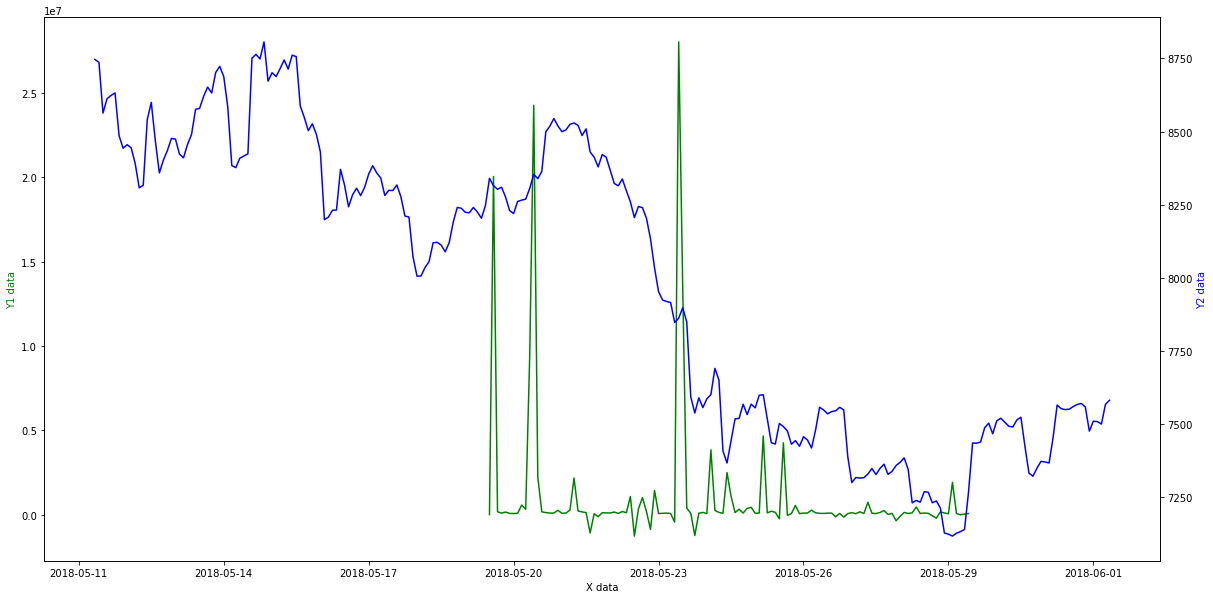

In [9]:
#
#plt.plot_date(tweets_grouped.index, tweets_grouped, ls='-', marker='o')
#plt.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, ls='-', marker='o')
#plt.show()

fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')
plt.show()

## Correlation analysis
Here we make the correlation analysis between BTC/USD currency derivative and the tweets scores derivative.

We can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

This Stackoverflow answer gives very useful details about correlating with time series.
https://stackoverflow.com/questions/6467832/how-to-get-the-correlation-between-two-timeseries-using-pandas

In [10]:
# Define the cross-correlation function

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method="pearson")

### Crop the time series to match the time frames

In [11]:
beggining = max(tweets_grouped.index.min(), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max(), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

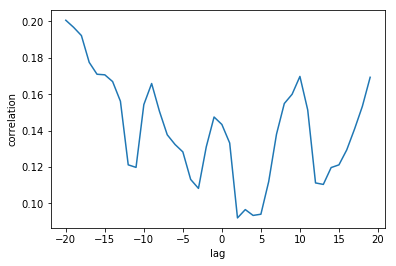

In [12]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Normalize 
First we need to normalize the data.

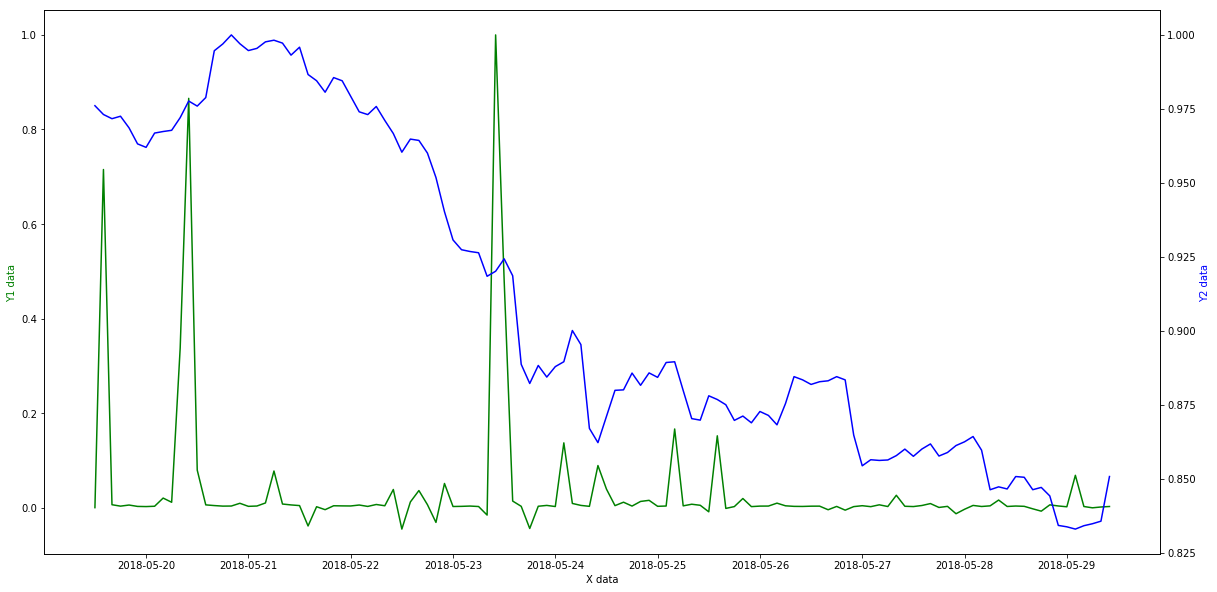

In [13]:
# Normalize time series data
tweets_grouped = tweets_grouped / max(tweets_grouped.max(), abs(tweets_grouped.min()))
crypto_usd_grouped = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))

fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')
plt.show()

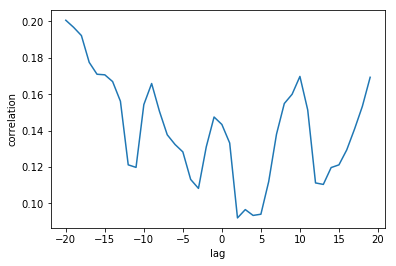

In [14]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Calculate derivative

In [15]:
# Derivative
tweets_grouped = pd.Series(np.gradient(tweets_grouped.values), tweets_grouped.index, name='slope')
crypto_usd_grouped = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

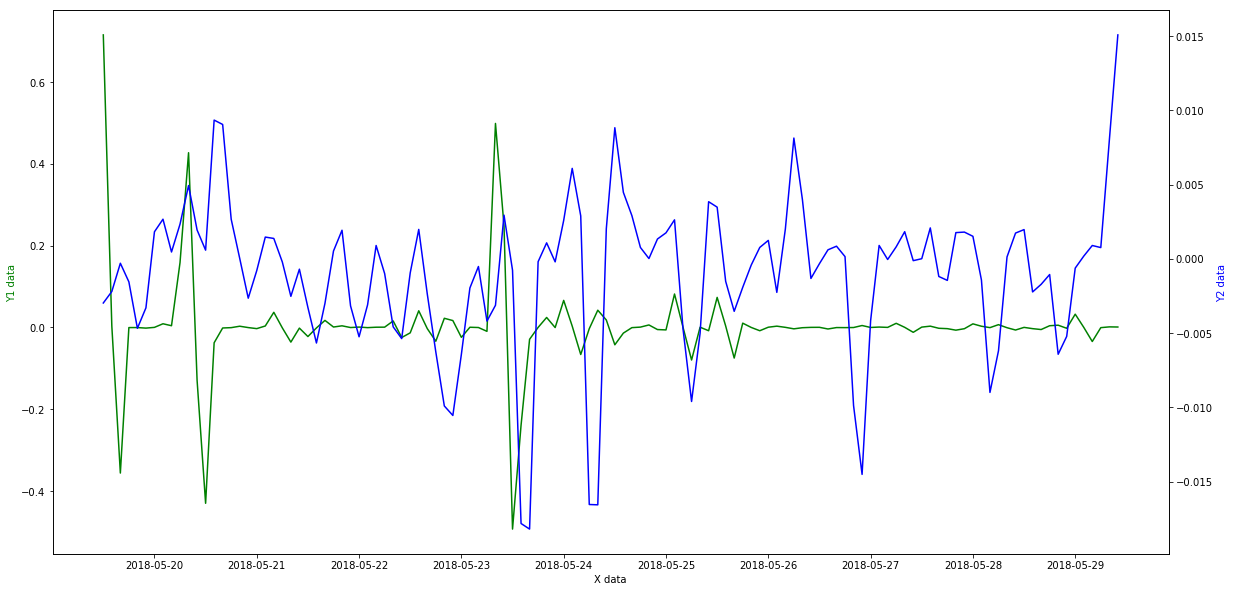

In [16]:
fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')
plt.show()

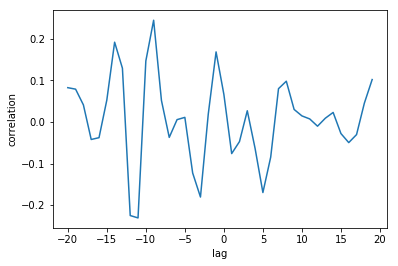

In [17]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Realtime correlation viewer
We can stream the new tweets about Bitcoin using the TwythonStreamer module. 

Using the CryptoCompare API we can also retrieve the BTC/USD currency in realtime using sockets.

Finally we can plot it with Plotly.

In [18]:
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime
from time import sleep
import plotly.tools as tls  

# Plot the real-time series graph

# Get stream id from stream id list
stream_id_crypto, stream_id_tweets = tls.get_credentials_file()['stream_ids'][:2]

# Make instance of stream id object 
stream_tweets = go.Stream(
    token=stream_id_tweets,  # link stream id to 'token' key
    maxpoints=1000      # keep a max of 80 pts on screen
)

stream_crypto = go.Stream(
    token=stream_id_crypto,  # link stream id to 'token' key
    maxpoints=200      # keep a max of 80 pts on screen
)

# Initialize trace of streaming plot by embedding the unique stream_id
trace_crypto = go.Scatter(x=[],y=[], stream=stream_crypto, name = CRYPTO_SYMBOL)
trace_tweets = go.Scatter(x=[], y=[], mode='lines', name='Sentiments', yaxis='y2', stream=stream_tweets)

#data = [trace_crypto, trace_tweets]
data = [trace_crypto, trace_tweets]

# Add title to layout object
layout = go.Layout(
    title=f"{CRYPTO_SYMBOL} currency and tweets sentiments",
    yaxis=dict(
        title='Price USD'
    ),
    yaxis2=dict(
        title='Sentiment score',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)

# Make a figure object
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename=f"real_time_{CRYPTO_SYMBOL}_tweets", fileopt="overwrite")

ValueError: not enough values to unpack (expected 2, got 0)

### Before continuing, run the crypto streamer first

Open your terminal and execute this command at the same level as this notebook. You first need to have [npm with node](https://www.npmjs.com/get-npm) installed on your machine.

- `cd streamer && npm install && node stream_crypto.js`

This line inside a jupyter notebook makes the cell block 

- `! cd streamer && node stream_crypto.js`

### Once this is done you can run the following cell to retrieve tweets

In [ ]:
from twython import TwythonStreamer
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# We will provide the stream link object the same token that's associated with the trace we wish to stream to
#s_crypto = py.Stream(stream_id_crypto)
s_tweets = py.Stream(stream_id_tweets)

# We then open a connection
#s_crypto.open()
s_tweets.open()

# Vader sentiment analyser
analyzer = SentimentIntensityAnalyzer()

class MyStreamer(TwythonStreamer):
    def on_success(self, data):
        if 'text' in data:
            # x value: date
            date_str = data['created_at']
            time_struct = time.strptime(date_str, "%a %b %d %H:%M:%S +0000 %Y")#Tue Apr 26 08:57:55 +0000 2011
            date = datetime.fromtimestamp(time.mktime(time_struct))
            date += timedelta(hours=2) # timezone
            
            # y value: sentiment of the tweet
            text = data['text']
            vs = analyzer.polarity_scores(text)
            score = vs["compound"] * (data["user"]["followers_count"]+1) * (data["favorite_count"]+1)
            #print(date, score)
            s_tweets.write(dict(type='scatter',
                 x=date,y=score))

    def on_error(self, status_code, data):
        print(status_code, data)

        # Want to stop trying to get data because of the error?
        # Uncomment the next line!
        # self.disconnect()
        
APP_KEY = 'mPQKoRwd2Pb9qpQyQmyG5s8KR'
APP_SECRET = 'HLvIhusvfzDLKaRXY8CnZGP143kp3E3f2KqQBIEMfVL5mOxZjq'
OAUTH_TOKEN = "3459248236-0XPtHldG3ou6BfpTwaKWnOL2ywFk2niQekLwE7K"
OAUTH_TOKEN_SECRET = "08Vy2wuOkp7AmuC3rbjCHFJ94MLG2sWqdvGQtoiXmkVKr"

stream = MyStreamer(APP_KEY, APP_SECRET,
                    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
stream.statuses.filter(track=['#bitcoin', '#BTC'], lang='en')

### To stop the real time data retrieving, stop the kernel in this notebook and press Ctrl+C in your terminal

In [ ]:
# Close the stream when done plotting
s_tweets.close() 